# Testing notebook for nifty fit on atmosphere TODs directly (no image)

# Try to add a nifty model for sampling the input map

numpy version: 2.1.1


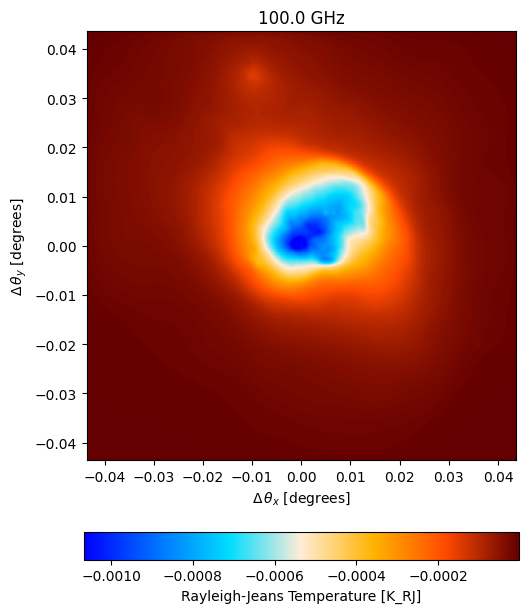

In [1]:
import numpy as np
print(f"numpy version: {np.__version__}")
import matplotlib.pyplot as plt
import maria
import sys
import os

# Relative import of sample_maps for now
sys.path.append(os.path.abspath('../python'))
import mapsampling_jax
from mapsampling_jax import sample_maps

map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

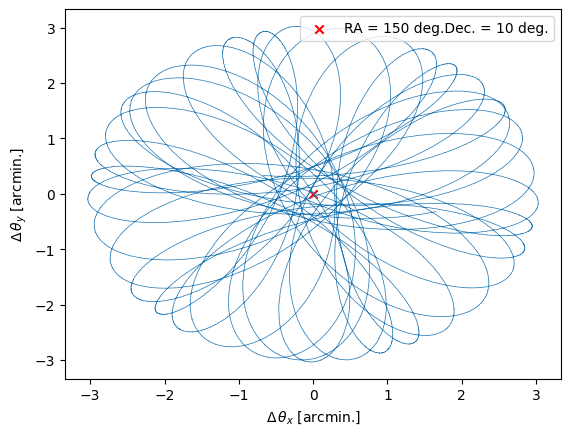

In [2]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                    # duration=60,
                    #   duration=300, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

2024-10-28 09:45:09.544 INFO: Initialized base in 1560 ms.
Building atmosphere: 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]
2024-10-28 09:45:15.341 INFO: Initialized atmosphere in 5781 ms.
Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


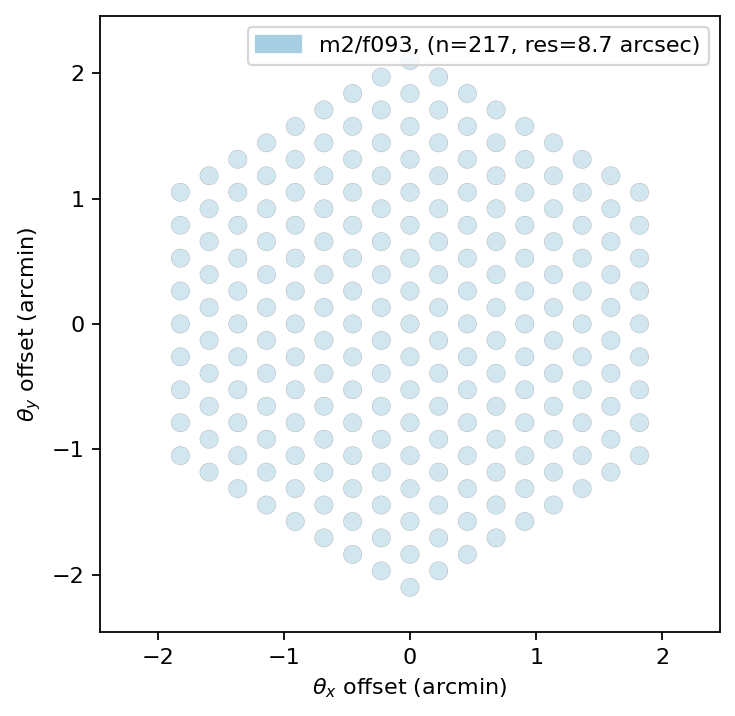

In [3]:
# instrument = maria.get_instrument('MUSTANG-2')
instrument = mapsampling_jax.instrument
instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                                plan=plan,
                                site="llano_de_chajnantor", 
                                map=input_map,
                                # noise=False,
                                atmosphere="2d",
                                # cmb="generate",
                                )

tod_truthmap = sim_truthmap.run()

In [4]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

dx

array([[-1.95590867e-04, -1.92674766e-04, -1.89783474e-04, ...,
         4.73503927e-04,  4.75969677e-04,  4.80311153e-04],
       [-2.44710050e-04, -2.41794046e-04, -2.38902825e-04, ...,
         4.28157310e-04,  4.30622971e-04,  4.34964165e-04],
       [-1.20400698e-04, -1.17484619e-04, -1.14593343e-04, ...,
         5.49381926e-04,  5.51847664e-04,  5.56189101e-04],
       ...,
       [ 1.22172448e-04,  1.25089341e-04,  1.27981223e-04, ...,
         7.60398809e-04,  7.62865287e-04,  7.67209064e-04],
       [-4.04158741e-04, -4.01241694e-04, -3.98349697e-04, ...,
         2.29252806e-04,  2.31719371e-04,  2.36063424e-04],
       [-7.44970260e-04, -7.42054221e-04, -7.39162973e-04, ...,
        -7.24573177e-05, -6.99916719e-05, -6.56505242e-05]])

Running mapper (m2/f093): 100%|██████████| 1/1 [00:05<00:00,  5.53s/it]


mapdata_truth shape: (1, 1, 1000, 1000)
mapdata_truth mean: -8.726028151723567e-05


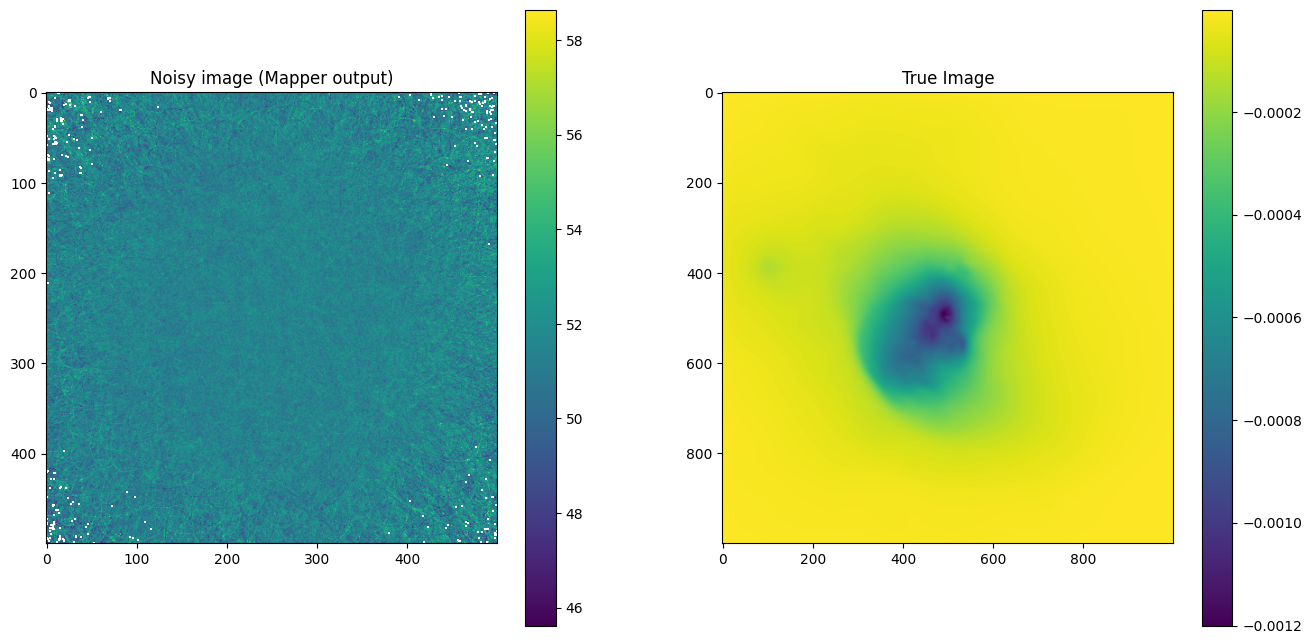

In [5]:
from maria.map.mappers import BinMapper

# Run mapper without any filtering to get noisy mimge
mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

print("mapdata_truth shape:", mapdata_truth.shape)
print("mapdata_truth mean:", mapdata_truth.mean())

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(output_truthmap.data[0].T)
fig.colorbar(im0)
axes[0].title.set_text("Noisy image (Mapper output)")

im1 = axes[1].imshow(mapdata_truth[0, 0])
fig.colorbar(im1)
axes[1].title.set_text("True Image")

plt.show()

# Re-implement map sampling in JAX for nifty response function:

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import jax
from jax import random
import jax.numpy as jnp

import nifty8.re as jft
import matplotlib.pyplot as plt

import numpy as np

from functools import reduce
from operator import or_

seed = 42
key = random.PRNGKey(seed)

2024-10-28 09:45:29.518 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-10-28 09:45:29.520 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


# Prepare noised input TODs:

Noise stddev: 0.000251873544654576


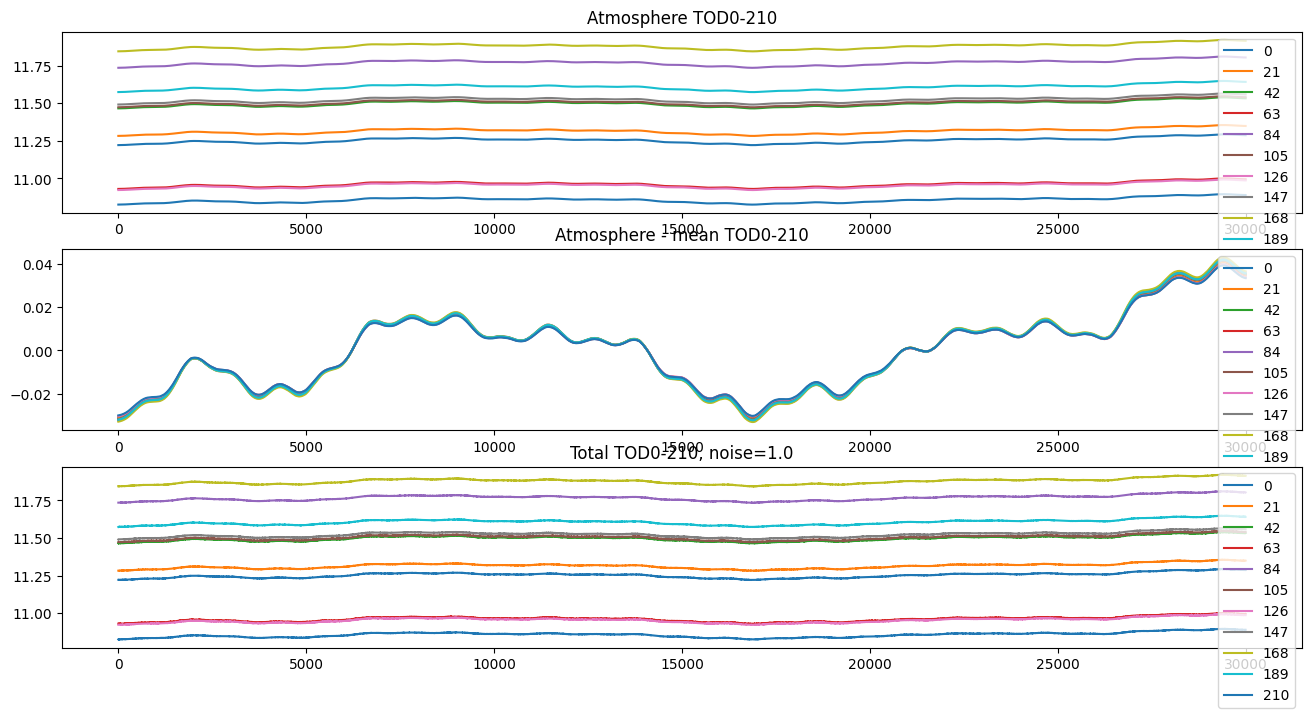

In [7]:
# Pick noise level for rest of run:
# noiselevel = 0.0
# noiselevel = 0.1
# noiselevel = 0.5
noiselevel = 1.0

jax_tods_atmos = tod_truthmap.get_field('atmosphere')

# Add n TODs for atmos:
# n = 1
# n = 2
# n = 10
# n = 100
n = jax_tods_atmos.shape[0]

noised_jax_tod = np.float64(jax_tods_atmos)[:n] + np.float64(tod_truthmap.get_field('noise')*noiselevel)[:n]
denoised_jax_tod = noised_jax_tod - np.float64(tod_truthmap.get_field('noise')*noiselevel)[:n]

print("Noise stddev:", np.std(tod_truthmap.get_field('noise').compute()))

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in range(0, n, n//10 if n//10 != 0 else 1):
    im0 = axes[0].plot(jax_tods_atmos[i], label=i)
    im1 = axes[1].plot(jax_tods_atmos[i] - jax_tods_atmos[i].mean(), label=i)
    im2 = axes[2].plot(noised_jax_tod[i], label=i)
    
axes[0].title.set_text(f'Atmosphere TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'Atmosphere - mean TOD0-{i}')
axes[1].legend()
axes[2].title.set_text(f'Total TOD0-{i}, noise={noiselevel}')
axes[2].legend()

plt.show()

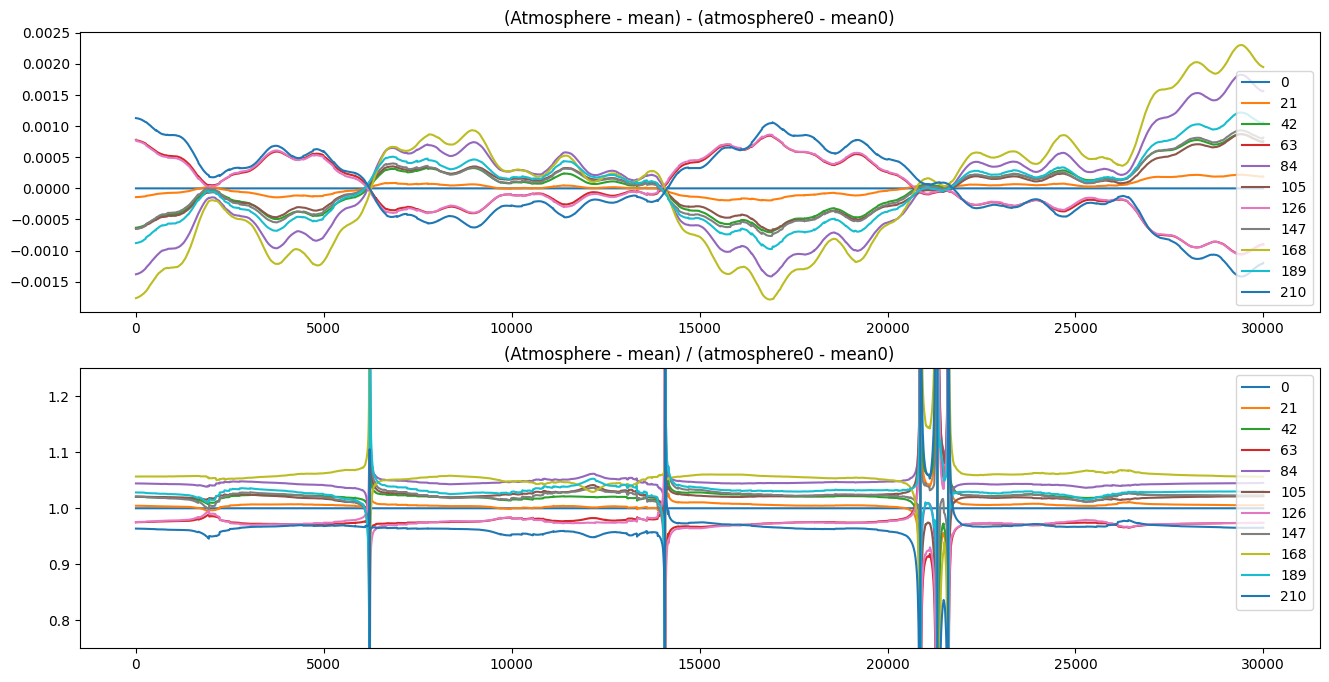

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in range(0, n, n//10 if n//10 != 0 else 1):
    axes[0].plot(jax_tods_atmos[i] - jax_tods_atmos[i].mean() - (jax_tods_atmos[0] - jax_tods_atmos[0].mean()), label=i)
    axes[1].plot( (jax_tods_atmos[i] - jax_tods_atmos[i].mean()) / (jax_tods_atmos[0] - jax_tods_atmos[0].mean()), label=i)
    
axes[0].title.set_text(f'(Atmosphere - mean) - (atmosphere0 - mean0)')
axes[0].legend()
axes[1].title.set_text(f'(Atmosphere - mean) / (atmosphere0 - mean0)')
axes[1].legend()
axes[1].set_ylim([0.75, 1.25])

plt.show()

In [9]:
print("real slopes:")
slopes_truth = (jax_tods_atmos - jax_tods_atmos.mean(axis=1)[:, None]) / (jax_tods_atmos[0] - jax_tods_atmos[0].mean())
# slopes_truth = (jax_tods_atmos) / (jax_tods_atmos[0])
# slice to regularise:
slopes_truth = slopes_truth[:, :5000].mean(axis=1)
print(slopes_truth.shape)

slopes_truth[0].compute()

real slopes:
(217,)


np.float64(1.0000000003538143)

# Get offsets:

deviation_mean: 3.4017511797706224e-15
deviation std: 0.5810399638649145
deviation_truth mean: 1.3783568585869647e-15
deviation_truth std: 0.5810397913733247


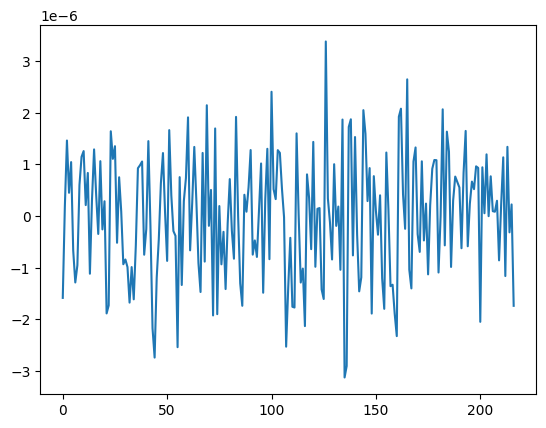

In [10]:
deviation_truth = (jax_tods_atmos - jax_tods_atmos.mean()).compute()
deviation = noised_jax_tod - noised_jax_tod.mean()

print("deviation_mean:", deviation.mean())
print("deviation std:", deviation.std())
print("deviation_truth mean:", deviation_truth.mean())
print("deviation_truth std:", deviation_truth.std())

offset_tod = jnp.float64(deviation.mean(axis=1)[:n])
offset_tod_truth = jnp.float64(deviation_truth.mean(axis=1)[:n])

plt.plot(offset_tod - offset_tod_truth)

# for testing:
# offset_tod = offset_tod_truth

np.float64(1.5344722440975534e-13)

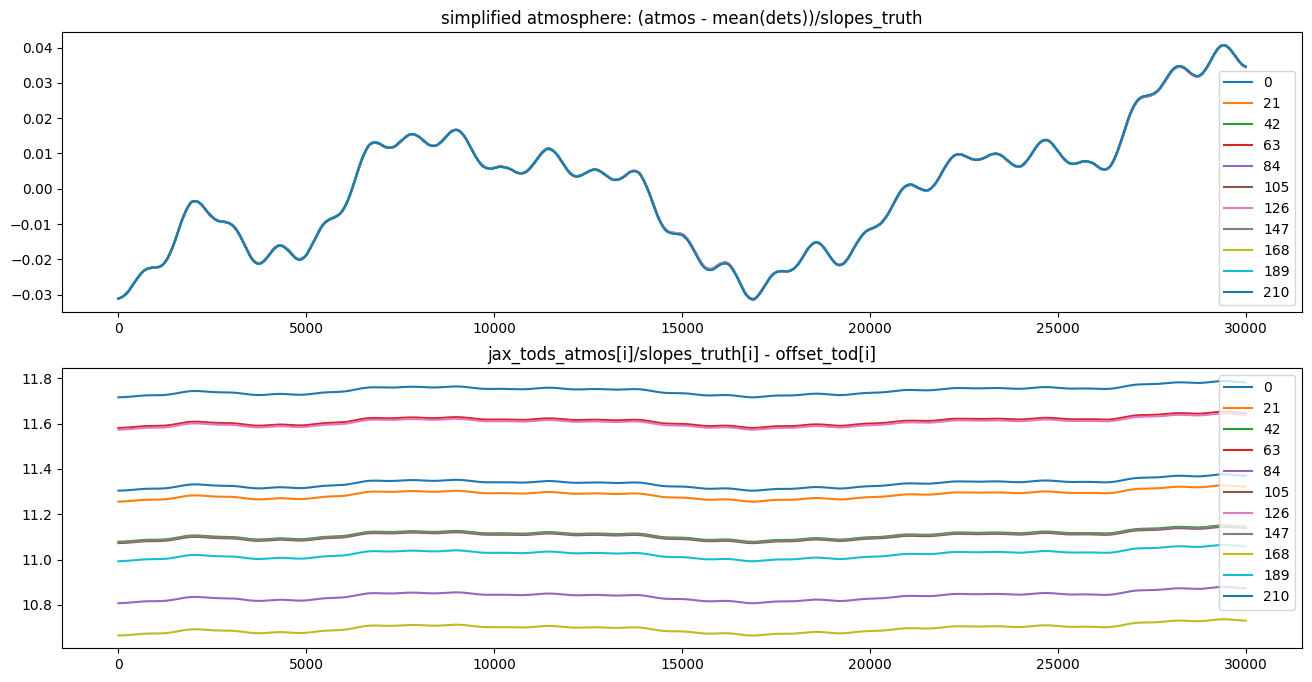

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# slopes_truth = (jax_tods_atmos - jax_tods_atmos.mean(axis=1)[:, None]) / (jax_tods_atmos[0] - jax_tods_atmos[0].mean())
# slopes_truth = (jax_tods_atmos - jax_tods_atmos.mean()) / (jax_tods_atmos[0] - jax_tods_atmos.mean())


offset_tod_truth = np.float64(jax_tods_atmos.mean(axis=1))
slopes_truth = np.float64(slopes_truth)
atmos_tod_simplified = (jax_tods_atmos - offset_tod_truth[:, None])/slopes_truth[:, None]

for i in range(0, n, n//10 if n//10 != 0 else 1):
    # axes[0].plot( (jax_tods_atmos[i] - jax_tods_atmos[i].mean())/slopes_truth[i], label=i)
    axes[0].plot( atmos_tod_simplified[i], label=i)

    axes[1].plot( (jax_tods_atmos[i]/slopes_truth[i] - offset_tod[i]), label=i)
    # axes[1].plot( (jax_tods_atmos[i] - offset_tod[i]), label=i)

axes[0].title.set_text(f'simplified atmosphere: (atmos - mean(dets))/slopes_truth')
axes[0].legend()
axes[1].title.set_text(f'jax_tods_atmos[i]/slopes_truth[i] - offset_tod[i]')
axes[1].legend()

atmos_tod_simplified.mean().compute()

# Next, initialise nifty prior model

Start with the atmosphere TOD model. For this, we need to re-write the CorrelatedFieldMaker:

In [12]:
import jax

import jax.numpy as jnp
import numpy as np
import nifty8.re as jft
import matplotlib.pyplot as plt

from functools import partial
from nifty8.re.correlated_field import Model, RegularCartesianGrid, hartley, HEALPixGrid, get_sht, ShapeWithDtype, random_like

key = jax.random.PRNGKey(42)

In [13]:
class CFM(jft.CorrelatedFieldMaker):
    def __init__(self, prefix):
        super().__init__(prefix)

    def finalize(self, n_fields: int = 0) -> Model:
        """Finishes off the model construction process and returns the
        constructed operator.
        """
        harmonic_transforms = []
        excitation_shape = ()
        for sgrid in self._target_grids:
            sub_shp = None
            sub_shp = sgrid.harmonic_grid.shape
            excitation_shape += sub_shp
            n = len(excitation_shape)
            harmonic_dvol = 1.0 / sgrid.total_volume
            if isinstance(sgrid, RegularCartesianGrid):
                axes = tuple(range(n - len(sub_shp), n))
                # TODO: Generalize to complex
                trafo = partial(hartley, axes=axes)
            elif isinstance(sgrid, HEALPixGrid):
                axis = len(excitation_shape) - 1
                trafo = get_sht(
                    nside=sgrid.nside,
                    axis=axis,
                    lmax=sgrid.harmonic_grid.lmax,
                    mmax=sgrid.harmonic_grid.mmax,
                    nthreads=1,
                )
            harmonic_transforms.append((harmonic_dvol, trafo))

        # Register the parameters for the excitations in harmonic space
        # TODO: actually account for the dtype here
        pfx = self._prefix + "xi"
        if n_fields > 0:
            xi_shape = (n_fields,) + excitation_shape
        else:
            xi_shape = excitation_shape
        self._parameter_tree[pfx] = ShapeWithDtype(xi_shape)

        def outer_harmonic_transform(p):
            harmonic_dvol, ht = harmonic_transforms[0]
            outer = harmonic_dvol * ht(p)
            for harmonic_dvol, ht in harmonic_transforms[1:]:
                outer = harmonic_dvol * ht(outer)
            return outer

        def _mk_expanded_amp(amp, sub_dom):  # Avoid late binding
            def expanded_amp(p):
                return amp(p)[sub_dom.harmonic_grid.power_distributor]

            return expanded_amp

        expanded_amplitudes = []
        namps = self.get_normalized_amplitudes()
        for amp, sgrid in zip(namps, self._target_grids):
            expanded_amplitudes.append(_mk_expanded_amp(amp, sgrid))

        def outer_amplitude(p):
            outer = expanded_amplitudes[0](p)
            for amp in expanded_amplitudes[1:]:
                # NOTE, the order is important here and must match with the
                # excitations
                # TODO, use functions instead and utilize numpy's casting
                outer = jnp.tensordot(outer, amp(p), axes=0)
            return outer

        def correlated_field(p):
            ea = outer_amplitude(p)
            cf_h = self.azm(p) * ea * p[self._prefix + "xi"]
            return self._offset_mean + outer_harmonic_transform(cf_h)
        
        p_dct = {k: 0 if 'xi' in k else None for k in self._parameter_tree}
        cfm_vmap = jax.vmap(correlated_field, in_axes=(p_dct,))

        init = {
            k: partial(random_like, primals=v) for k, v in self._parameter_tree.items()
        }
        cf = Model(cfm_vmap, domain=self._parameter_tree.copy(), init=init)
        cf.normalized_amplitudes = namps
        cf.target_grids = tuple(self._target_grids)
        return cf

In [14]:
# padding_atmos = 2000
# padding_atmos = 5000
padding_atmos = 10000
dims_atmos = ( (jax_tods_atmos.shape[1] + padding_atmos), )
# dims_atmos = ( (jax_tods_atmos.shape[1] - 200 + padding_atmos), )

# correlated field zero mode GP offset and stddev
# cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.0002, 0.0001))
# cf_zm_tod = dict(offset_mean=0.0, offset_std=(0.0002, 0.0001))
# cf_zm_tod = dict(offset_mean=0.0, offset_std=(1e-6, 0.5e-6))
cf_zm_tod = dict(offset_mean=0.0, offset_std=(1e-5, 0.99e-5))

# correlated field fluctuations (mostly don't need tuning)
# fluctuations: y-offset in power spectrum in fourier space (zero mode)
# loglogavgslope: power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
# flexibility=(1.5e0, 5e-1), # deviation from simple power-law
# asperity=(5e-1, 5e-2), # small scale features in power-law
cf_fl_tod = dict(
    # fluctuations=(0.005, 0.003), 
    # fluctuations=(0.001, 0.0005),
    fluctuations=(0.002, 0.001),
    # loglogavgslope=(-3, 0.5), 
    # loglogavgslope=(-2, 0.5), 
    loglogavgslope=(-2.5, 0.5), 
    flexibility=None,
    asperity=None,
)

# put together in correlated field model
# Custom CFM:
cfm_tod = CFM("combcf ")
cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
cfm_tod.add_fluctuations(
    dims_atmos, distances=1.0 / dims_atmos[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
)
gp_tod = cfm_tod.finalize(n)
gp_tod

# Old: default CFM:
# cfm_tod = jft.CorrelatedFieldMaker("")
# cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
# cfm_tod.add_fluctuations(
#     dims_atmos, distances=1.0 / dims_atmos[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
# )
# # init params for each TOD:
# gps_tods = []
# for i in range(n):
#     cfmi = jft.CorrelatedFieldMaker(f'tod{i} ')
#     # cfmi.set_amplitude_total_offset(**cf_zm_tod)
#     cfmi._azm = cfm_tod._azm
#     cfmi._offset_mean = cfm_tod._offset_mean
#     cfmi._parameter_tree['zeromode'] = jft.ShapeWithDtype(())

#     cfmi._fluctuations.append(cfm_tod._fluctuations[0])
#     cfmi._target_grids.append(cfm_tod._target_grids[0])
#     cfmi._parameter_tree.update(cfm_tod._fluctuations[0].domain)
#     gps_tods.append(cfmi.finalize())
# gps_tods

Model(
	<function CFM.finalize.<locals>.correlated_field at 0x1546b4aef740>,
	domain={'combcf tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf xi': ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>),
	 'combcf zeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer(
		{'combcf tod fluctuations': functools.partial(<function random_like at 0x15469c9ea480>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf tod loglogavgslope': functools.partial(<function random_like at 0x15469c9ea480>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf xi': functools.partial(<function random_like at 0x15469c9ea480>, primals=ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>)),
		 'combcf zeromode': functools.partial(<function random_like at 0x1

# Define offset NormalPrior:

In [15]:
# offset_dict = dict(mean = 0.0, std = 0.6, shape=(n,))
# offset_tod = jft.NormalPrior(**offset_dict, name='offset')

# offset_tod

# OLD Signal model:

In [16]:
# class Signal_TOD(jft.Model):
#     def __init__(self, gps_tods):
#         self.gps_tods = gps_tods
#         self.tgt = (len(gps_tods), gps_tods[0].target.size)
#         super().__init__(init=reduce(or_, [gp.init for gp in gps_tods]), domain=reduce(or_, [gp.domain for gp in gps_tods]))
    
#     def __call__(self, x):
#         res_tods = jnp.zeros(self.tgt)
#         for i, gp in enumerate(self.gps_tods):
#             res_tods = res_tods.at[i].set(gp(x))
        
#         return res_tods[:, padding_atmos//2:-padding_atmos//2]

# signal_response_tod = Signal_TOD(gps_tods)

# CFM - TOD

In [17]:
class Signal_TOD(jft.Model):
    def __init__(self, gp_tod, offset_tod):
        self.gp_tod = gp_tod
        self.offset_tod = offset_tod
        # super().__init__(init = self.gp_tod.init | self.offset_tod.init, domain = self.gp_tod.domain | self.offset_tod.domain )
        super().__init__(init = self.gp_tod.init, domain = self.gp_tod.domain )
    
    def __call__(self, x):
        x_tod = {k: x[k] for k in x if 'comb' in k}
        res_tods = self.gp_tod(x_tod)
        # res_tods = self.gp_tod(x)

        # For offset NormalPrior:
        # res_tods = res_tods[:, padding_atmos//2:-padding_atmos//2] + self.offset_tod(x)[:, jax.numpy.newaxis]
        # For fixed offsets:
        # res_tods = res_tods[:, padding_atmos//2:-padding_atmos//2] + self.offset_tod[:, jax.numpy.newaxis]
        # For simple inputs:
        # res_tods = res_tods[:, padding_atmos//2:-padding_atmos//2]
        # Reverse de-trending:
        res_tods = res_tods[:, padding_atmos//2:-padding_atmos//2] * slopes_truth[:, None] + offset_tod_truth[:, None]

        return res_tods

signal_response_tod = Signal_TOD(gp_tod, offset_tod)

In [18]:
# Define noise covariance
# if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x
if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 1e-8**-2 * x
elif noiselevel == 0.1: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 0.5: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 1.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x

# Test with simple atmos TODs:
# noised_jax_tod = np.float64(atmos_tod_simplified)[:n] + np.float64(tod_truthmap.get_field('noise')*noiselevel)[:n]
# denoised_jax_tod = np.float64(atmos_tod_simplified)[:n]

# Combine in likelihood
truth = noised_jax_tod[:n]

print(truth.shape)
lh_tod = jft.Gaussian( truth, noise_cov_inv_tod).amend(signal_response_tod)

# lh = lh_tod + lh_map
# lh = lh_map
lh = lh_tod

# lh_map_grad = jax.grad(lh_map)
lh_tod_grad = jax.grad(lh_tod)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


(217, 30000)


In [19]:
signal_response_tod

Signal_TOD(
	<bound method Signal_TOD.__call__>,
	domain={'combcf tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf xi': ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>),
	 'combcf zeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer(
		{'combcf tod fluctuations': functools.partial(<function random_like at 0x15469c9ea480>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf tod loglogavgslope': functools.partial(<function random_like at 0x15469c9ea480>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf xi': functools.partial(<function random_like at 0x15469c9ea480>, primals=ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>)),
		 'combcf zeromode': functools.partial(<function random_like at 0x15469c9ea480>, primals=ShapeW

# Draw Prior sample

(217, 30000)


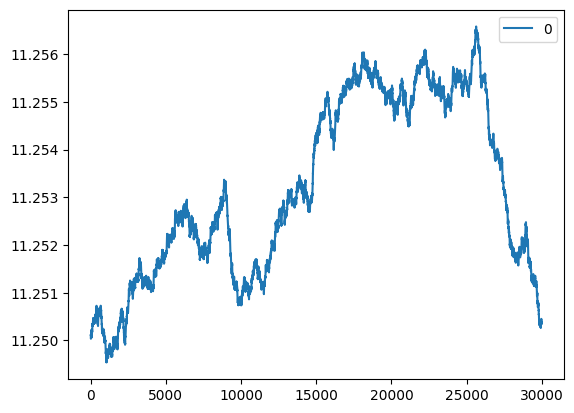

In [20]:
key, sub = jax.random.split(key)
xi = jft.random_like(sub, signal_response_tod.domain)
res = signal_response_tod(xi)
print(res.shape)

# for i in range(res.shape[0]):
# for i in range(0, n, n//10):
for i in [0]:
    plt.plot(np.arange(0, res.shape[1]), res[i], label=i)
plt.legend()
plt.show()

# MAP fit

In [21]:
n_it = 1
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4

n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60 # map
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=20 # map
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001
M: →:1.0 ↺:False #∇²:06 |↘|:1.052088e+04 ➽:8.680003e+02
M: Iteration 1 ⛰:+8.847637e+09 Δ⛰:7.395505e+09
M: →:0.125 ↺:False #∇²:12 |↘|:2.418444e+03 ➽:8.680003e+02
M: Iteration 2 ⛰:+7.699778e+09 Δ⛰:1.147859e+09
M: →:0.5 ↺:False #∇²:18 |↘|:2.013349e+04 ➽:8.680003e+02
M: Iteration 3 ⛰:+1.685713e+09 Δ⛰:6.014064e+09
M: →:1.0 ↺:False #∇²:24 |↘|:2.477449e+03 ➽:8.680003e+02
M: Iteration 4 ⛰:+4.951731e+08 Δ⛰:1.190540e+09
M: →:1.0 ↺:False #∇²:30 |↘|:2.250324e+03 ➽:8.680003e+02
M: Iteration 5 ⛰:+2.849928e+08 Δ⛰:2.101803e+08
M: →:1.0 ↺:False #∇²:36 |↘|:3.103985e+03 ➽:8.680003e+02
M: Iteration 6 ⛰:+2.237615e+08 Δ⛰:6.123130e+07
M: →:1.0 ↺:False #∇²:42 |↘|:2.196973e+03 ➽:8.680003e+02
M: Iteration 7 ⛰:+1.885517e+08 Δ⛰:3.520982e+07
M: →:1.0 ↺:False #∇²:48 |↘|:2.558884e+03 ➽:8.680003e+02
M: Iteration 8 ⛰:+1.617829e+08 Δ⛰:2.676881e+07
M: →:1.0 ↺:False #∇²:54 |↘|:1.379804e+03 ➽:8.680003e+02
M: Iteration 9 ⛰:+1.439661e+08 Δ⛰:1.781680e+07
M: →:1.0 ↺:False #∇²:61 |↘|:1.373752e+04 ➽:8

In [22]:
samples.pos

Vector(
	{'combcf tod fluctuations': Array(1.31501516, dtype=float64),
	 'combcf tod loglogavgslope': Array(1.49853309, dtype=float64),
	 'combcf xi': Array([[  0.97709195,   4.23978346,   7.16244307, ...,   1.81562564,
	        -13.90232602,  -1.74048761],
	       [  0.64190533,   4.24194715,   7.22766971, ...,   2.24808213,
	        -13.6748861 ,  -1.68463273],
	       [  1.59370388,   4.29562561,   7.47898994, ...,   2.16268799,
	        -13.82189005,  -1.76787431],
	       ...,
	       [  0.92187757,   4.15558353,   7.02040875, ...,   2.58327153,
	        -13.59120455,  -1.63910921],
	       [  0.14402042,   4.30957577,   7.49405071, ...,   1.99398908,
	        -13.92174956,  -1.76701359],
	       [  2.04691432,   4.2080875 ,   7.25082517, ...,   2.4191196 ,
	        -13.65347221,  -1.69228817]], dtype=float64),
	 'combcf zeromode': Array(-0.88437101, dtype=float64)}
)

In [23]:
def printfitresults():
    print("Fit Results (res, init, std)")

    print("\nTODs:")
    # NEW model:
    print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_tod['fluctuations'])(samples.pos['combcf tod fluctuations'])}, {cf_fl_tod['fluctuations'][0]}, {cf_fl_tod['fluctuations'][1]}")
    print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_tod['loglogavgslope'])(samples.pos['combcf tod loglogavgslope'])}, {cf_fl_tod['loglogavgslope'][0]}, {cf_fl_tod['loglogavgslope'][1]}")
    print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_tod['offset_std'])(samples.pos['combcf zeromode'])}, {cf_zm_tod['offset_std'][0]}, {cf_zm_tod['offset_std'][1]}")
    # OLD model:
    # print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_tod['fluctuations'])(samples.pos['tod fluctuations'])}, {cf_fl_tod['fluctuations'][0]}, {cf_fl_tod['fluctuations'][1]}")
    # print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_tod['loglogavgslope'])(samples.pos['tod loglogavgslope'])}, {cf_fl_tod['loglogavgslope'][0]}, {cf_fl_tod['loglogavgslope'][1]}")
    # print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_tod['offset_std'])(samples.pos['zeromode'])}, {cf_zm_tod['offset_std'][0]}, {cf_zm_tod['offset_std'][1]}")

    # offset per detector:
    # offset_results = jft.NormalPrior(**offset_dict)(samples.pos['offset'])
    # print(f"\toffset: ({offset_results.mean()}, {offset_results.std()}), {offset_dict['mean']}, {offset_dict['std']}")
    # # residual offset:
    # offset_residuals = offset_results - jnp.float64(deviation.mean(axis=1)[:n].compute())
    # print(f"\toffset residuals: ({offset_residuals.mean()}, {offset_residuals.std()})")

    # If custom zeromode per TOD:
    # for i in range(n):
    #     test = samples.pos[f"tod{i} zeromode"]
    #     print(f"tod{i} zeromode: {jft.LogNormalPrior(cf_zm_tod['offset_mean'], cf_zm_tod['offset_std'][0])(test)}, {cf_zm_tod['offset_mean']}, {cf_zm_tod['offset_std'][0]}")
    
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.003329303826218561, 0.002, 0.001
	loglogvarslope: -1.7507334571610287, -2.5, 0.5
	zeromode std (LogNormal): 3.4214165111295616e-06, 1e-05, 9.9e-06


(217, 30000)


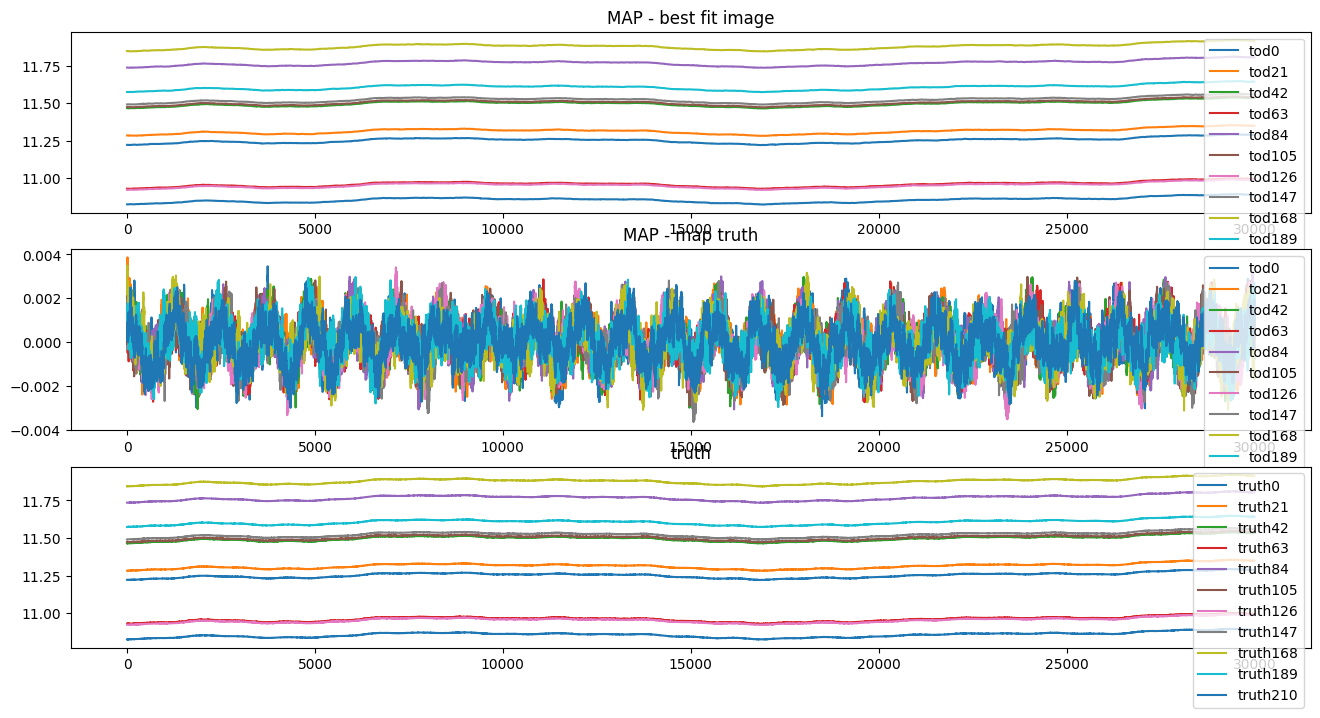

In [24]:
res = signal_response_tod(samples.pos)
print(res.shape)

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in range(0, n, n//10 if n//10 != 0 else 1):
    im0 = axes[0].plot(np.arange(0, res.shape[1]), res[i], label=f"tod{i}")
    im1 = axes[1].plot(np.arange(0, res.shape[1]), res[i] - truth[i], label=f"tod{i}")
    im2 = axes[2].plot(truth[i], label=f"truth{i}")

axes[0].title.set_text('MAP - best fit image')
axes[0].legend()
axes[1].title.set_text('MAP - map truth')
axes[1].legend()
axes[2].title.set_text('truth')
axes[2].legend()

plt.show()

In [25]:
# assert False

## Full nifty fit:

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+8.9576e+07 Δ⛰:inf ➽:8.6800e+01
SL: Iteration 1 ⛰:+6.2924e+07 Δ⛰:2.6653e+07 ➽:8.6800e+01
SL: Iteration 2 ⛰:+9.3980e+06 Δ⛰:5.3526e+07 ➽:8.6800e+01
SL: Iteration 3 ⛰:+8.2172e+06 Δ⛰:1.1808e+06 ➽:8.6800e+01
SL: Iteration 4 ⛰:+4.3910e+06 Δ⛰:3.8261e+06 ➽:8.6800e+01
SL: Iteration 5 ⛰:+7.3429e+05 Δ⛰:3.6567e+06 ➽:8.6800e+01
SL: Iteration 6 ⛰:-9.1221e+05 Δ⛰:1.6465e+06 ➽:8.6800e+01
SL: Iteration 7 ⛰:-1.2243e+06 Δ⛰:3.1211e+05 ➽:8.6800e+01
SL: Iteration 8 ⛰:-1.2417e+06 Δ⛰:1.7377e+04 ➽:8.6800e+01
SL: Iteration 9 ⛰:-1.8474e+06 Δ⛰:6.0572e+05 ➽:8.6800e+01
SL: Iteration 10 ⛰:-2.5081e+06 Δ⛰:6.6064e+05 ➽:8.6800e+01
SL: Iteration 11 ⛰:-2.6726e+06 Δ⛰:1.6451e+05 ➽:8.6800e+01
SL: Iteration 12 ⛰:-2.8705e+06 Δ⛰:1.9794e+05 ➽:8.6800e+01
SL: Iteration 13 ⛰:-3.0570e+06 Δ⛰:1.8647e+05 ➽:8.6800e+01
SL: Iteration 14 ⛰:-3.1238e+06 Δ⛰:6.6791e+04 ➽:8.6800e+01
SL: Iteration 15 ⛰:-3.1544e+06 Δ⛰:3.0653e+04 ➽:8.6800e+01
SL: Iteration 16 ⛰:-3.2998e+06 Δ⛰:1.4538e+05 ➽:8.6800e+01
SL: 

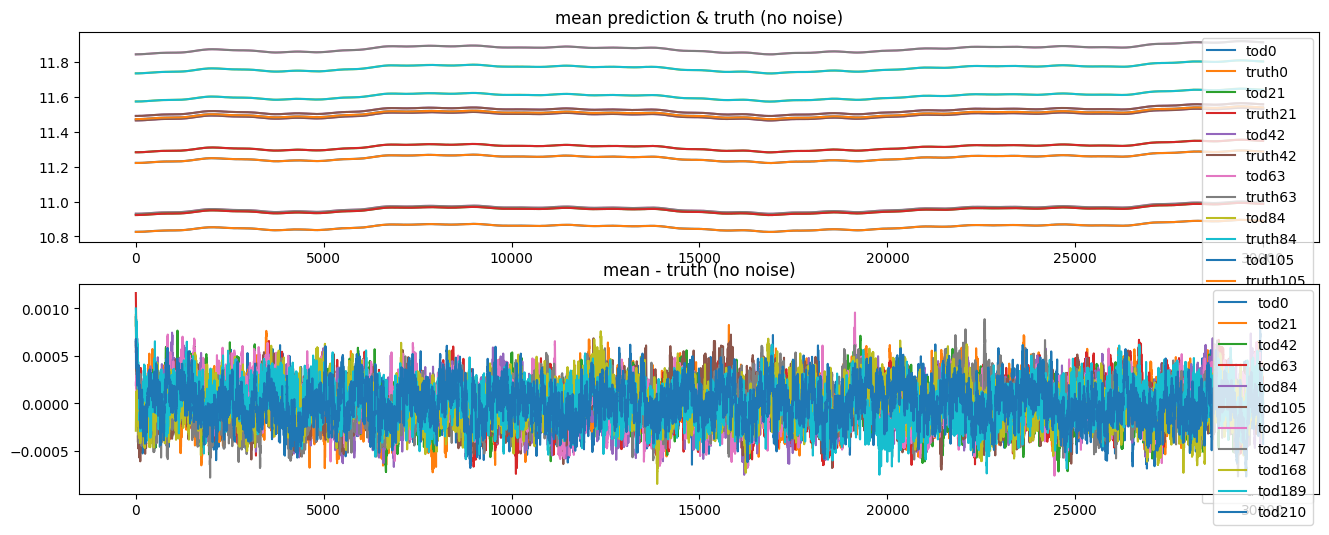

OPTIMIZE_KL: Starting 0003
SL: Iteration 0 ⛰:+2.5179e+09 Δ⛰:inf ➽:8.6800e+01
SL: Iteration 1 ⛰:+1.2411e+08 Δ⛰:2.3938e+09 ➽:8.6800e+01
SL: Iteration 2 ⛰:+1.0171e+08 Δ⛰:2.2397e+07 ➽:8.6800e+01
SL: Iteration 3 ⛰:+3.2735e+07 Δ⛰:6.8979e+07 ➽:8.6800e+01
SL: Iteration 4 ⛰:+2.1387e+07 Δ⛰:1.1348e+07 ➽:8.6800e+01
SL: Iteration 5 ⛰:+2.0954e+07 Δ⛰:4.3248e+05 ➽:8.6800e+01
SL: Iteration 6 ⛰:+1.3667e+07 Δ⛰:7.2871e+06 ➽:8.6800e+01
SL: Iteration 7 ⛰:+1.1035e+07 Δ⛰:2.6317e+06 ➽:8.6800e+01
SL: Iteration 8 ⛰:+1.1001e+07 Δ⛰:3.4473e+04 ➽:8.6800e+01
SL: Iteration 9 ⛰:+8.0380e+06 Δ⛰:2.9629e+06 ➽:8.6800e+01
SL: Iteration 10 ⛰:+8.0189e+06 Δ⛰:1.9135e+04 ➽:8.6800e+01
SL: Iteration 11 ⛰:+6.2963e+06 Δ⛰:1.7226e+06 ➽:8.6800e+01
SL: Iteration 12 ⛰:+5.3654e+06 Δ⛰:9.3089e+05 ➽:8.6800e+01
SL: Iteration 13 ⛰:+4.0344e+06 Δ⛰:1.3309e+06 ➽:8.6800e+01
SL: Iteration 14 ⛰:+3.9948e+06 Δ⛰:3.9640e+04 ➽:8.6800e+01
SL: Iteration 15 ⛰:+3.9945e+06 Δ⛰:3.3104e+02 ➽:8.6800e+01
SL: Iteration 16 ⛰:+3.3229e+06 Δ⛰:6.7152e+05 ➽:8.6800e+01
SL: 

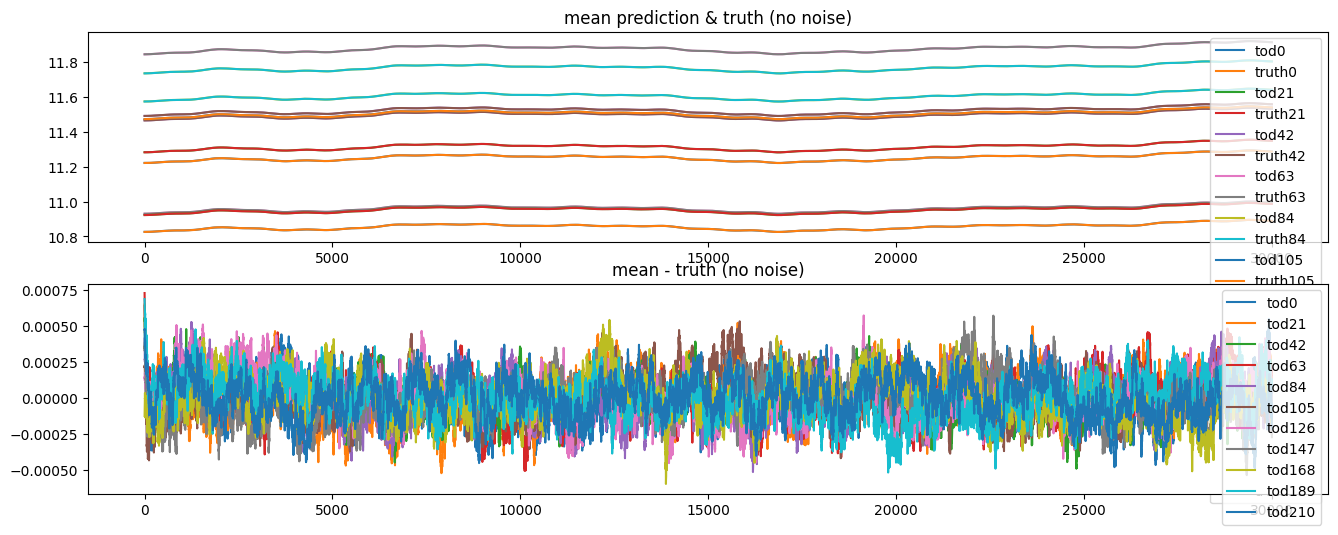

OPTIMIZE_KL: Starting 0005
SL: Iteration 0 ⛰:+4.1624e+08 Δ⛰:inf ➽:8.6800e+01
SL: Iteration 1 ⛰:+2.3113e+08 Δ⛰:1.8510e+08 ➽:8.6800e+01
SL: Iteration 2 ⛰:+1.2461e+08 Δ⛰:1.0653e+08 ➽:8.6800e+01
SL: Iteration 3 ⛰:+3.5176e+07 Δ⛰:8.9431e+07 ➽:8.6800e+01
SL: Iteration 4 ⛰:+2.2436e+07 Δ⛰:1.2741e+07 ➽:8.6800e+01
SL: Iteration 5 ⛰:+1.2853e+07 Δ⛰:9.5826e+06 ➽:8.6800e+01
SL: Iteration 6 ⛰:+1.2722e+07 Δ⛰:1.3053e+05 ➽:8.6800e+01
SL: Iteration 7 ⛰:+9.5885e+06 Δ⛰:3.1339e+06 ➽:8.6800e+01
SL: Iteration 8 ⛰:+9.5386e+06 Δ⛰:4.9905e+04 ➽:8.6800e+01
SL: Iteration 9 ⛰:+7.0762e+06 Δ⛰:2.4623e+06 ➽:8.6800e+01
SL: Iteration 10 ⛰:+4.5070e+06 Δ⛰:2.5692e+06 ➽:8.6800e+01
SL: Iteration 11 ⛰:+4.5067e+06 Δ⛰:3.6272e+02 ➽:8.6800e+01
SL: Iteration 12 ⛰:+3.6858e+06 Δ⛰:8.2084e+05 ➽:8.6800e+01
SL: Iteration 13 ⛰:+2.7950e+06 Δ⛰:8.9088e+05 ➽:8.6800e+01
SL: Iteration 14 ⛰:+2.7927e+06 Δ⛰:2.2111e+03 ➽:8.6800e+01
SL: Iteration 15 ⛰:+1.8776e+06 Δ⛰:9.1517e+05 ➽:8.6800e+01
SL: Iteration 16 ⛰:+1.8774e+06 Δ⛰:2.0274e+02 ➽:8.6800e+01
SL: 

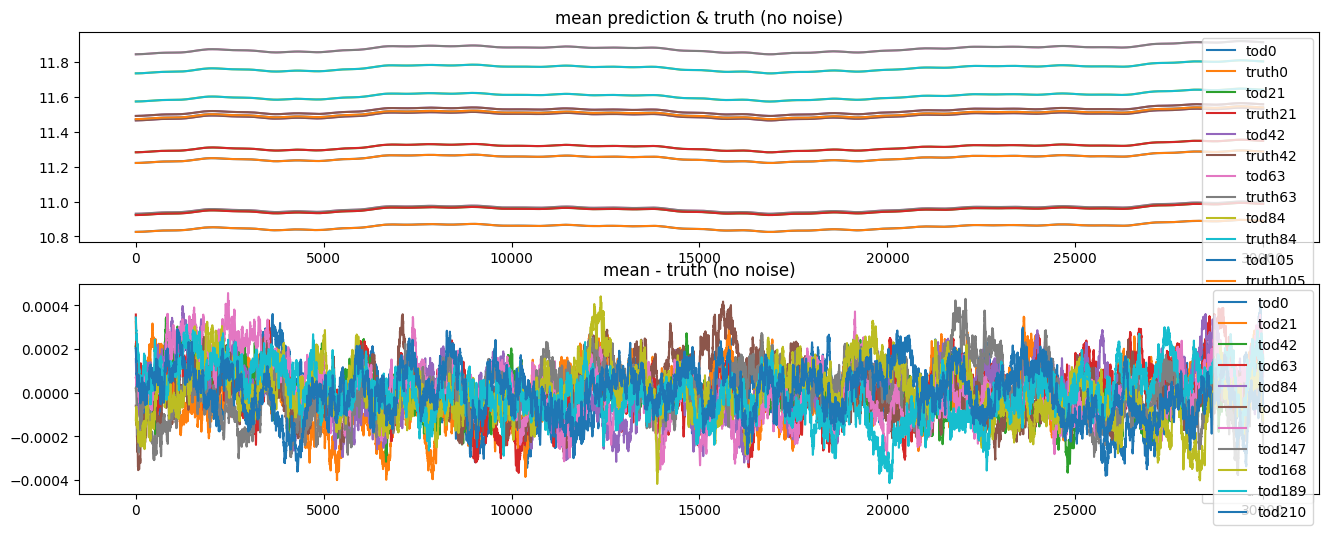

OPTIMIZE_KL: Starting 0007
SL: Iteration 0 ⛰:+2.1776e+08 Δ⛰:inf ➽:8.6800e+01
SL: Iteration 1 ⛰:+1.8104e+08 Δ⛰:3.6719e+07 ➽:8.6800e+01
SL: Iteration 2 ⛰:+1.8041e+08 Δ⛰:6.2432e+05 ➽:8.6800e+01
SL: Iteration 3 ⛰:+4.5089e+07 Δ⛰:1.3532e+08 ➽:8.6800e+01
SL: Iteration 4 ⛰:+2.8817e+07 Δ⛰:1.6272e+07 ➽:8.6800e+01
SL: Iteration 5 ⛰:+1.5569e+07 Δ⛰:1.3248e+07 ➽:8.6800e+01
SL: Iteration 6 ⛰:+1.5568e+07 Δ⛰:1.5276e+03 ➽:8.6800e+01
SL: Iteration 7 ⛰:+1.0860e+07 Δ⛰:4.7079e+06 ➽:8.6800e+01
SL: Iteration 8 ⛰:+1.0156e+07 Δ⛰:7.0383e+05 ➽:8.6800e+01
SL: Iteration 9 ⛰:+8.8399e+06 Δ⛰:1.3160e+06 ➽:8.6800e+01
SL: Iteration 10 ⛰:+5.5503e+06 Δ⛰:3.2897e+06 ➽:8.6800e+01
SL: Iteration 11 ⛰:+4.0504e+06 Δ⛰:1.4999e+06 ➽:8.6800e+01
SL: Iteration 12 ⛰:+3.9856e+06 Δ⛰:6.4781e+04 ➽:8.6800e+01
SL: Iteration 13 ⛰:+3.1993e+06 Δ⛰:7.8635e+05 ➽:8.6800e+01
SL: Iteration 14 ⛰:+2.4165e+06 Δ⛰:7.8270e+05 ➽:8.6800e+01
SL: Iteration 15 ⛰:+2.4125e+06 Δ⛰:4.0572e+03 ➽:8.6800e+01
SL: Iteration 16 ⛰:+1.6680e+06 Δ⛰:7.4451e+05 ➽:8.6800e+01
SL: 

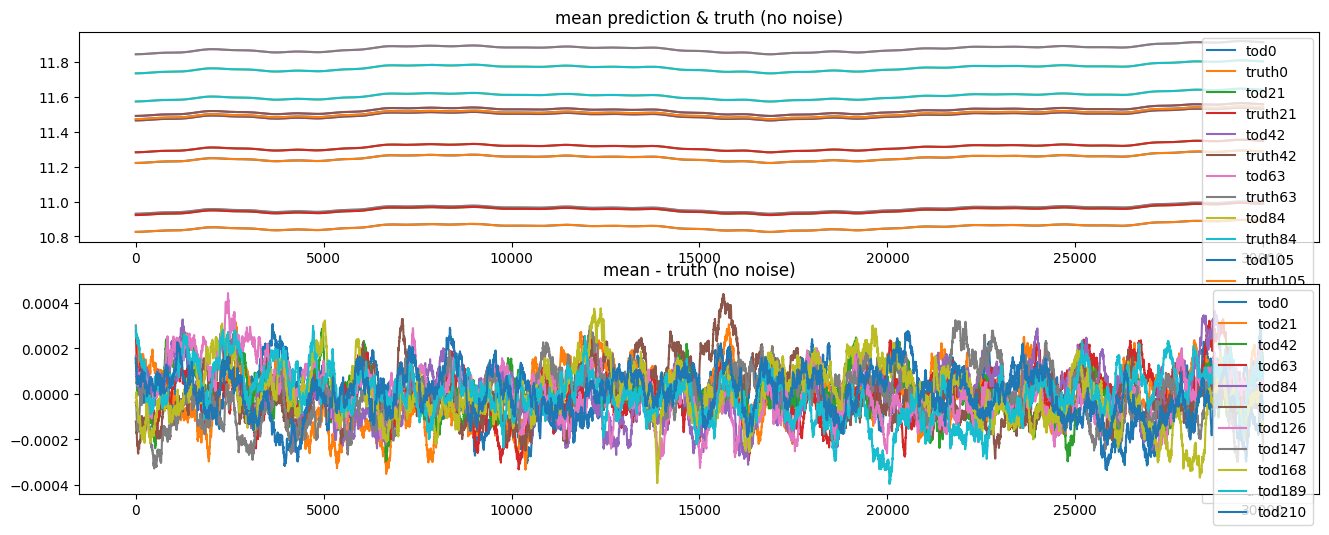

OPTIMIZE_KL: Starting 0009
SL: Iteration 0 ⛰:+6.7845e+09 Δ⛰:inf ➽:8.6800e+01
SL: Iteration 1 ⛰:+2.8346e+08 Δ⛰:6.5010e+09 ➽:8.6800e+01
SL: Iteration 2 ⛰:+2.1280e+08 Δ⛰:7.0659e+07 ➽:8.6800e+01
SL: Iteration 3 ⛰:+4.3449e+07 Δ⛰:1.6935e+08 ➽:8.6800e+01
SL: Iteration 4 ⛰:+2.7440e+07 Δ⛰:1.6009e+07 ➽:8.6800e+01
SL: Iteration 5 ⛰:+1.5553e+07 Δ⛰:1.1887e+07 ➽:8.6800e+01
SL: Iteration 6 ⛰:+1.5245e+07 Δ⛰:3.0832e+05 ➽:8.6800e+01
SL: Iteration 7 ⛰:+9.1259e+06 Δ⛰:6.1192e+06 ➽:8.6800e+01
SL: Iteration 8 ⛰:+9.1173e+06 Δ⛰:8.5442e+03 ➽:8.6800e+01
SL: Iteration 9 ⛰:+7.6421e+06 Δ⛰:1.4752e+06 ➽:8.6800e+01
SL: Iteration 10 ⛰:+4.5470e+06 Δ⛰:3.0951e+06 ➽:8.6800e+01
SL: Iteration 11 ⛰:+4.5465e+06 Δ⛰:4.4426e+02 ➽:8.6800e+01
SL: Iteration 12 ⛰:+2.6763e+06 Δ⛰:1.8702e+06 ➽:8.6800e+01
SL: Iteration 13 ⛰:+2.1384e+06 Δ⛰:5.3791e+05 ➽:8.6800e+01
SL: Iteration 14 ⛰:+1.2744e+06 Δ⛰:8.6397e+05 ➽:8.6800e+01
SL: Iteration 15 ⛰:+1.2646e+06 Δ⛰:9.8407e+03 ➽:8.6800e+01
SL: Iteration 16 ⛰:+1.0858e+06 Δ⛰:1.7876e+05 ➽:8.6800e+01
SL: 

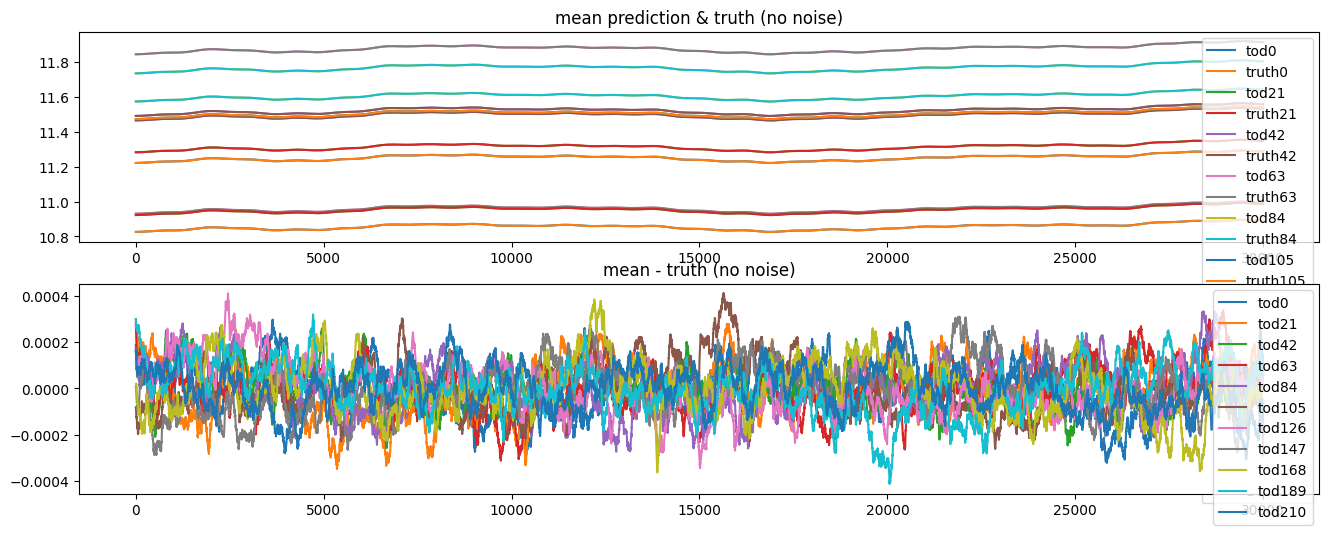

In [26]:
n_it = 10
# n_it = 30
# n_it = 50

if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4
n_samples = 4 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    if opt_state[0] % 2 != 0: return 
    
    mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

    fig_tods, axes_tods = plt.subplots(2, 1, figsize=(16, 6))

    for i in range(0, n, n//10 if n//10 != 0 else 1):
        axes_tods[0].plot(np.arange(0, mean.shape[1]), mean[i], label=f"tod{i}")
        axes_tods[0].plot(denoised_jax_tod[i], label=f"truth{i}")
        axes_tods[1].plot(np.arange(0, mean.shape[1]), mean[i] - denoised_jax_tod[i], label=f"tod{i}")

    axes_tods[0].title.set_text('mean prediction & truth (no noise)')
    axes_tods[0].legend()
    axes_tods[1].title.set_text('mean - truth (no noise)')
    axes_tods[1].legend()

    plt.show()
    

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
        # cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=10),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=10
        )
    ),
    # sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    sample_mode = lambda x: "nonlinear_resample" if x >= 1 else "linear_resample",
    callback=callback,
)

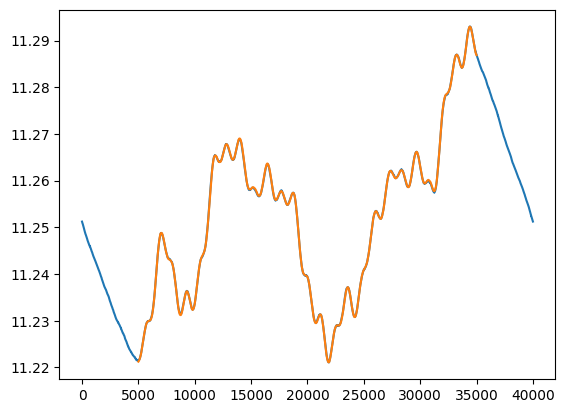

In [27]:
# offset_results = jft.NormalPrior(**offset_dict)(samples.pos['offset'])
# offset_results = offset_tod
pred = gp_tod({k: samples.pos[k] for k in samples.pos if 'comb' in k}) * slopes_truth[:, None] + offset_tod_truth[:, None]
padded_truth = np.pad(denoised_jax_tod[0], pad_width=padding_atmos//2, mode='constant', constant_values=np.nan)

plt.plot(pred[0])
plt.plot(padded_truth)

In [28]:
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.001700703457270106, 0.002, 0.001
	loglogvarslope: -2.4174537963770906, -2.5, 0.5
	zeromode std (LogNormal): 2.9121932013820485e-05, 1e-05, 9.9e-06


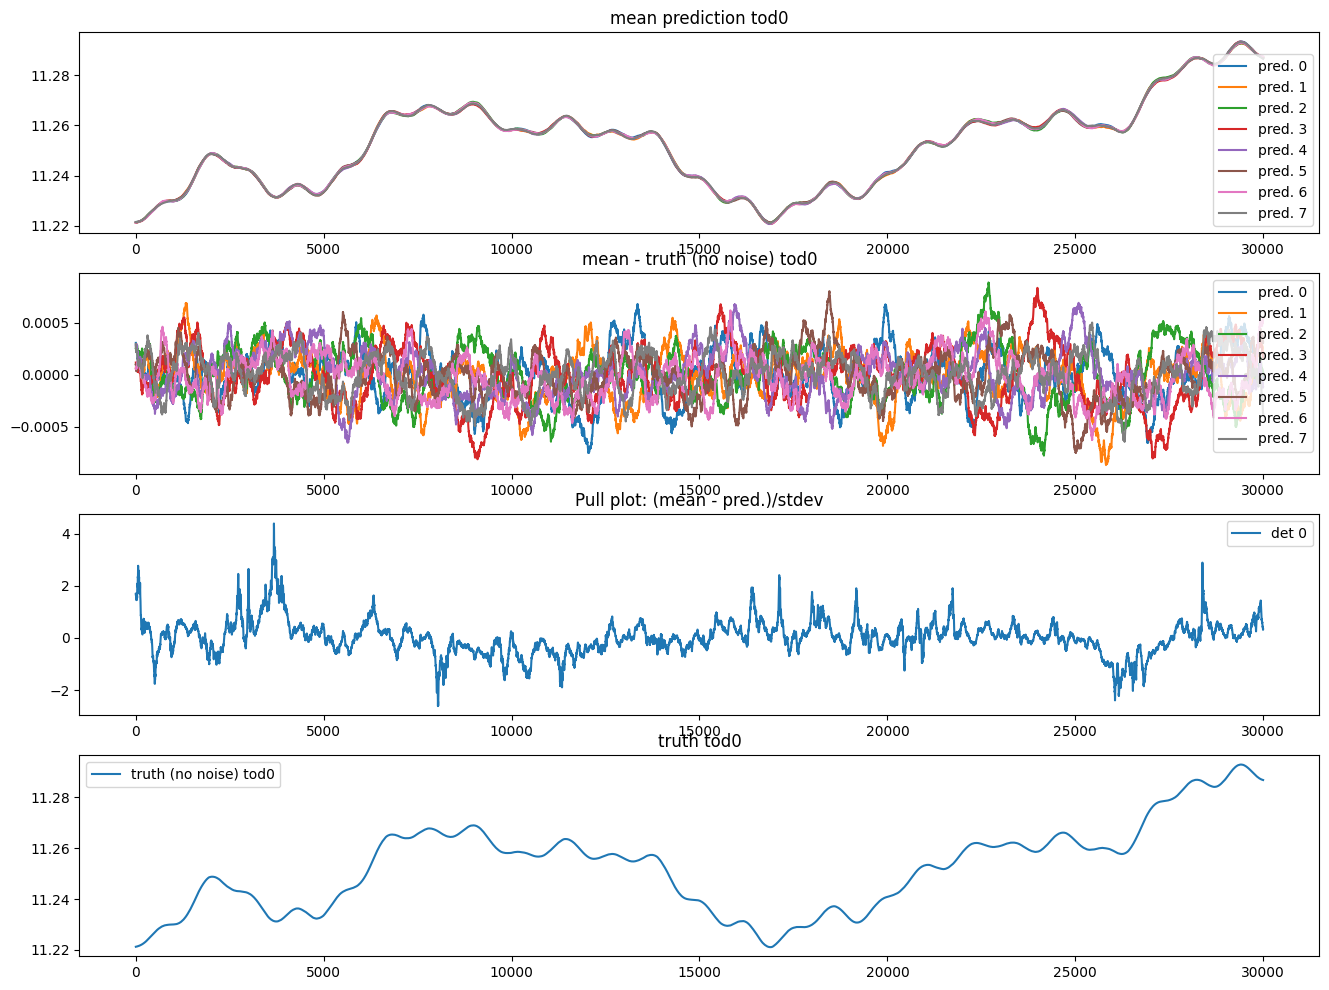

In [29]:
mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 0 # TOD id
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i], label=f"pred. {j}")
    # im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i, 100:-100], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i])/std[i], label=f"det {i}")
# im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i, 100:-100])/std[i], label=f"det {i}")
im3 = axes[3].plot(denoised_jax_tod[i], label=f"truth (no noise) tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth (no noise) tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()

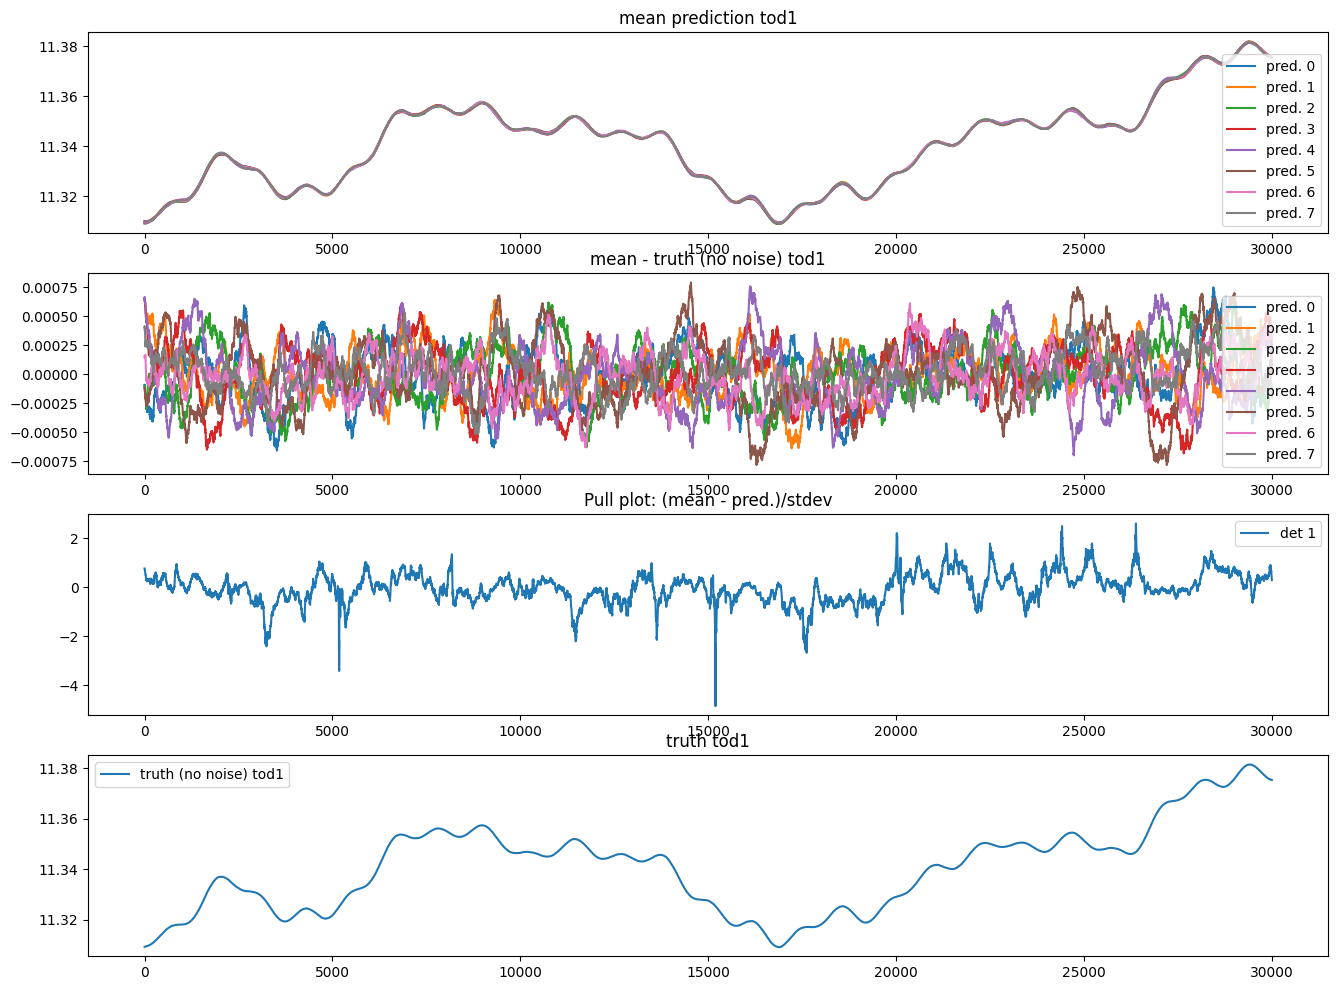

In [30]:
mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 1 # TOD id
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i], label=f"pred. {j}")
    # im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i, 100:-100], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i])/std[i], label=f"det {i}")
# im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i, 100:-100])/std[i], label=f"det {i}")
im3 = axes[3].plot(denoised_jax_tod[i], label=f"truth (no noise) tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth (no noise) tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()